In [7]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

import numpy as np
import math
import pandas as pd
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 30)
#pd.options.display.float_format = '{:,}'.format 





In [8]:
def enum_category(label):
    num=0
    if label == 'Poor' : num =1
    elif label == 'Fair': num = 2
    elif label == 'Average': num = 3
    elif label == 'Good': num = 4
    elif label == 'Very Good': num = 5
    else: return label
    
    return int(num)

def log_and_normalize (data, log, norm_type):
    if log == 'log':
        data = np.log(data) 
    if norm_type == 1:
        data = (data-np.mean(data))/np.std(data)  # std normalisation
    elif norm_type == 2:
        data = (data-min(data))/(max(data)-min(data))      #  min_max_min
    elif norm_type == 3:
        data = (data-np.mean(data))/(max(data)-min(data))  # mean norm
    
    return data    

def hot_encode (data, directions):
    if directions == 'yes':
        data = pd.get_dummies(data, prefix=data.name[:3], drop_first=True)
    return data

In [9]:
df=pd.read_csv('data/kc_house_data.csv', index_col=0)

# initial cleaning operations (dropping columns, splitting , etc)
#df.drop(columns=["waterfront",'view'],inplace=True)
#df.drop(columns=["waterfront"],inplace=True)

df["grade"]=df["grade"].map(lambda x: x.split()[0]).astype(int)
df['condition'] = df['condition'].apply(enum_category)




In [10]:
# Prepairing data
#df.drop(df.index[df["bedrooms"]==33], inplace=True)

df['renovated']=np.where((df['yr_renovated'].isna() |  df['yr_renovated'] == 0), 0, 1)
df['yr_renovated'].fillna(value=df['yr_built'],inplace=True)
df['yr_renovated'] = np.where(df['yr_renovated'] == 0, df['yr_built'], df['yr_renovated'])

df['waterfront'].fillna(value='NO',inplace=True)




#df['sqft_basement'].replace('?', '0', inplace=True)
df=df[df['sqft_basement'] != '?']
df['sqft_basement']=df['sqft_basement'].astype(float).astype(int)
df['basement']= np.where(df['sqft_basement'] < 30, 0, 1)


df['sqft_basement'] = np.where((df['sqft_basement'] < 100) & (df['sqft_basement'] > -1), 1, df['sqft_basement'])
df['sqft_basement']=np.where((df['sqft_basement']==-1) & (df['sqft_living']-df['sqft_above']<=400), 
                             1, df['sqft_basement'])
df['sqft_basement']=np.where((df['sqft_basement']==-1) & (df['sqft_living']-df['sqft_above']>400) 
                             & (df['sqft_above']/df['sqft_living']<0.70),
                             (df['sqft_living']-df['sqft_above'])*0.75/df['floors'], df['sqft_basement'])
df['sqft_basement'] = np.where (df['sqft_basement'] == -1, 1, df['sqft_basement'])



#NEW FEATURES

df["age"]=2016-df['yr_built']
df["years_after_renovation"]=2016-df['yr_renovated']
df['month_of_sale']=df['date'].apply(lambda x: str.split(x,'/')[0]).astype(int)

df['after_1980']= np.where(df['yr_built'] >= 1980, 1, 0)
df['before_1940']= np.where(df['yr_built'] <= 1940, 1, 0)


df['same_living_sqft']=(df['sqft_living']-df['sqft_living15'])/df['sqft_living'] 
df['same_lot_sqft']=(df['sqft_lot']-df['sqft_lot15'])/df['sqft_lot'] 



df['lat_range']=pd.cut(df['lat'], 30)
df['long_range']=pd.cut(df['long'], 30)
df['coord_range']=np.array(zip(df['lat_range'],df['long_range']))
df['decade']=pd.cut(df['yr_built'], 12)


#FILTER
#df=df[df['yr_built']>1980]
#df=df[df['price']<3000000].copy()
df=df[df['sqft_living']<7000].copy()
df=df[df['sqft_lot']<100000].copy()
df=df[~df["grade"].isin([3,4,5])]



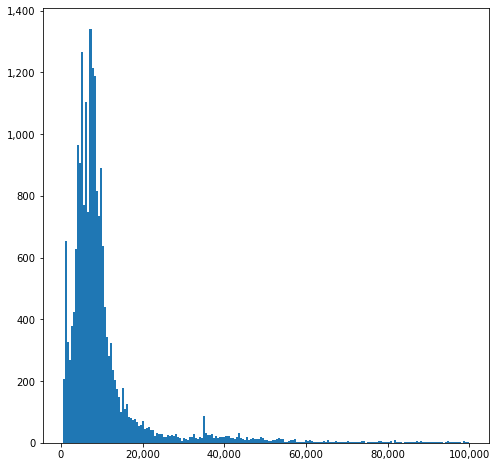

In [11]:

#df['sqft_lot'].max()
#df['sqft_lot'].hist(figsize=(8,10), bins=50);

fig,ax = plt.subplots(figsize = (8,8))
ax.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.hist(df['sqft_lot'], bins=200);


In [12]:
#num=df.select_dtypes(include=[np.number]).drop("price", axis=1)
price=df[["price"]]

other=[]
#cont=["sqft_living", 'sqft_lot', 'sqft_living15']
cont=["sqft_living", 'sqft_lot', 'sqft_living15']

cat=[ "grade", 'zipcode', 'yr_built','waterfront','view']


#cont=["sqft_living"]
#cat=[ 'grade', 'zipcode', 'view', 'waterfront','yr_built']


data_fin=pd.DataFrame([])


asis=df[other]



In [13]:
# Log transform and normalize
for col in cont:
    data_fin[col]=log_and_normalize(df[col], 'log', 0)

data_fin["sqft_living"]=log_and_normalize(df["sqft_living"], 'nolog', 0)
data_fin["sqft_lot"]=log_and_normalize(df["sqft_lot"], 'log', 0)
data_fin["condition"]=log_and_normalize(df["condition"], 'log', 0)
price=log_and_normalize(price, 'log', 0)

In [14]:
# One hot encode categoricals
for col in cat:
    new_cols=hot_encode(df[col], 'yes')
    data_fin = pd.concat([data_fin, new_cols], axis=1)


In [15]:
data_fin = pd.concat([price, data_fin, asis], axis=1)

#pd.plotting.scatter_matrix(data_fin,figsize  = [14, 14]);


In [16]:
#Create OLS MODEL

pred=data_fin.drop(columns=["price"]).copy()

pred_int = sm.add_constant(pred)
model = sm.OLS(price,pred_int).fit()
model.rsquared_adj





0.8848426043697

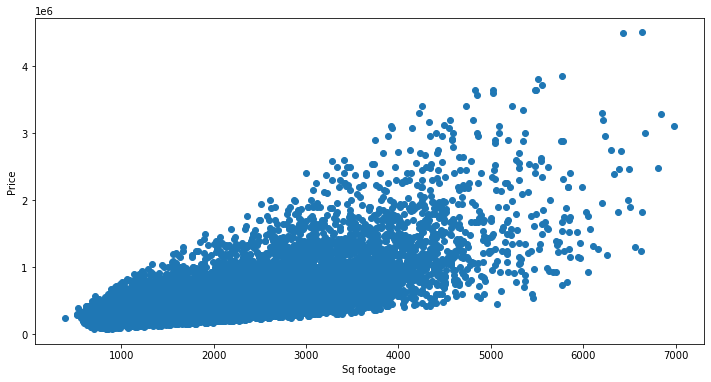

In [17]:
sales_pred = model.predict()
sales_pred
plt.figure(figsize=(12, 6))
plt.plot(df['sqft_living'], df['price'], 'o')  
#plt.plot(pred_int['sqft_living'], sales_pred, 'r', linewidth=2)
plt.xlabel('Sq footage')
plt.ylabel('Price')
plt.show()

In [18]:
#results=[]
#combs=data_fin.drop("price", axis=1).columns
##combs=num
#for comb in itertools.combinations(combs, 1):
#    test=data_fin[list(comb)].copy()
#    prep = sm.add_constant(test[list(comb)])
#    model = sm.OLS(price, prep).fit()
#    results.append([comb, model.rsquared_adj])
#
#pd.DataFrame(results).sort_values(1, ascending=False)



In [74]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(pred,price)
linreg.score(pred, price)

0.8837133416889124

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

pred_train, pred_test, price_train, price_test = train_test_split(pred, price, test_size=0.3)

In [76]:
linreg = LinearRegression()
linreg.fit(pred_train, price_train)
linreg.score(pred_train, price_train)

0.8838291239702816

In [77]:
y_train = linreg.predict(pred_train)
y_test = linreg.predict(pred_test)

In [78]:
#train_residuals = y_train - price_train
#test_residuals = y_test - price_test

In [79]:
#mse_train = np.sum((price_train-y_train)**2)/len(price_train)
#mse_test = np.sum((price_test-y_test)**2)/len(price_test)
#print('Train Mean Squarred Error:', mse_train)
#print('Test Mean Squarred Error:', mse_test)

In [80]:
#mse_train

In [81]:
train_mse = mean_squared_error(price_train, y_train)
test_mse = mean_squared_error(price_test, y_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.03229826412063358
Test Mean Squarred Error: 0.032462632025625805


In [86]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

cv_5_results  = np.mean(cross_val_score(linreg, pred, price, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, pred, price, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, pred, price, cv=20, scoring='neg_mean_squared_error'))


In [87]:
print(cv_5_results, cv_10_results, cv_20_results)

-5.059813702472261e+22 -8416062646724.065 -1567120185924.8823
